# Widerface EDA

In [108]:
import os
import numpy as np
import pandas as pd
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

## Training data

In [3]:
DATA_DIR = './data/widerface'

In [17]:
!head -n 8 ./data/widerface/train/label.txt

# 0--Parade/0_Parade_marchingband_1_849.jpg
449 330 122 149 488.906 373.643 0.0 542.089 376.442 0.0 515.031 412.83 0.0 485.174 425.893 0.0 538.357 431.491 0.0 0.82
# 0--Parade/0_Parade_Parade_0_904.jpg
361 98 263 339 424.143 251.656 0.0 547.134 232.571 0.0 494.121 325.875 0.0 453.83 368.286 0.0 561.978 342.839 0.0 0.89
# 0--Parade/0_Parade_marchingband_1_799.jpg
78 221 7 8 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 0.2
78 238 14 17 84.188 244.607 1.0 89.527 244.491 1.0 86.973 247.857 1.0 85.116 250.643 1.0 88.482 250.643 1.0 0.36
113 212 11 15 117.0 220.0 0.0 122.0 220.0 0.0 119.0 222.0 0.0 118.0 225.0 0.0 122.0 225.0 0.0 0.3


In [151]:
def parse_label_line(line):
    label = line.split(' ')
    label = [float(x) for x in label]
    bbox = label[:4]
    bbox[2] += bbox[0]
    bbox[3] += bbox[1]
    landmarks = [label[i] for i in [4, 5, 7, 8, 10, 11, 13, 14, 16, 17]]
    if label[4] < 0:
        landmarks.append(-1)
    else:
        landmarks.append(1)
    return bbox + landmarks

def load_train_labels(file_name):
    with open(file_name, 'r') as f:
        lines = [x.rstrip() for x in f.readlines()]
    
    labels = []
    for line in lines:
        if line.startswith('#'):
            names = line[2:].split('/')
            event_name = names[0]
            img_name = names[1].split('.')[0]
            
            labels.append({
                'event_name': event_name,
                'img_name': img_name,
                'annotation': []
            })
        else:
            labels[-1]['annotation'].append(parse_label_line(line))
    
    return pd.DataFrame(labels)

In [152]:
train = load_train_labels(f'{DATA_DIR}/train/label.txt')

In [153]:
train.head()

event_name                     img_name  \
0  0--Parade  0_Parade_marchingband_1_849   
1  0--Parade        0_Parade_Parade_0_904   
2  0--Parade  0_Parade_marchingband_1_799   
3  0--Parade  0_Parade_marchingband_1_117   
4  0--Parade  0_Parade_marchingband_1_778   

                                          annotation  
0  [[449.0, 330.0, 571.0, 479.0, 488.906, 373.643...  
1  [[361.0, 98.0, 624.0, 437.0, 424.143, 251.656,...  
2  [[78.0, 221.0, 85.0, 229.0, -1.0, -1.0, -1.0, ...  
3  [[69.0, 359.0, 119.0, 395.0, 92.232, 391.397, ...  
4  [[27.0, 226.0, 60.0, 262.0, -1.0, -1.0, -1.0, ...

In [154]:
train['num_bboxes'] = train.annotation.map(lambda x: len(x))

In [155]:
train['num_landmarks'] = train.annotation.map(lambda anns: len(list(filter(lambda x: x[4] > 0, anns))))

In [156]:
train.tail()

event_name                                   img_name  \
12875  9--Press_Conference  9_Press_Conference_Press_Conference_9_614   
12876  9--Press_Conference  9_Press_Conference_Press_Conference_9_791   
12877  9--Press_Conference  9_Press_Conference_Press_Conference_9_280   
12878  9--Press_Conference  9_Press_Conference_Press_Conference_9_131   
12879  9--Press_Conference  9_Press_Conference_Press_Conference_9_266   

                                              annotation  num_bboxes  \
12875  [[462.0, 140.0, 726.0, 502.0, 489.384, 279.759...           1   
12876  [[362.0, 108.0, 576.0, 385.0, 414.165, 215.241...           1   
12877  [[495.0, 222.0, 660.0, 444.0, 541.286, 288.429...           1   
12878  [[244.0, 46.0, 754.0, 660.0, 284.638, 295.045,...           1   
12879  [[400.0, 150.0, 608.0, 440.0, 434.455, 252.71,...           1   

       num_landmarks  
12875              1  
12876              1  
12877              1  
12878              1  
12879              1

### Total training samples

In [30]:
train.shape

(12880, 3)

### Total bounding boxes / faces

In [49]:
train.num_bboxes.sum()

159424

In [59]:
train.num_bboxes.sum() / train.shape[0]

12.377639751552795

In [56]:
train.num_bboxes.max()

1968

### Total landmarks

In [50]:
train.num_landmarks.sum()

75933

In [60]:
train.num_landmarks.sum() / train.shape[0]

5.8954192546583855

In [58]:
train.num_landmarks.max()

269

We can see that there are 50% bounding boxes / faces have corresponding landmarks.

### Face / landmark number distribution

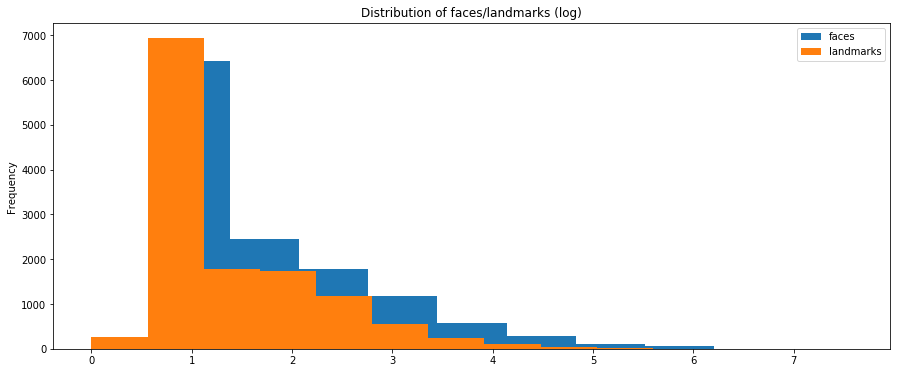

In [63]:
plt.figure(figsize=(15, 6))
plt.title('Distribution of faces/landmarks (log)');
np.log1p(train['num_bboxes']).plot(kind='hist', label='faces');
np.log1p(train['num_landmarks']).plot(kind='hist', label='landmarks');
plt.legend();


In [85]:
np.log1p(1)

0.6931471805599453

In [86]:
print(train[train['num_bboxes']==1].shape[0], train[train['num_bboxes']==2].shape[0], train[train['num_bboxes']==3].shape[0])

4635 1793 827


In [91]:
train[train['num_bboxes']<=12].shape[0] / train.shape[0]

0.8033385093167702

Insights: 80% images have less than 13 faces

In [87]:
print(train[train['num_landmarks']==1].shape[0], train[train['num_landmarks']==2].shape[0], train[train['num_landmarks']==3].shape[0])

4976 1959 987


### Events

In [48]:
train['event_name'].unique()

array(['0--Parade', '1--Handshaking', '10--People_Marching',
       '11--Meeting', '12--Group', '13--Interview', '14--Traffic',
       '15--Stock_Market', '16--Award_Ceremony', '17--Ceremony',
       '18--Concerts', '19--Couple', '2--Demonstration',
       '20--Family_Group', '21--Festival', '22--Picnic', '23--Shoppers',
       '24--Soldier_Firing', '25--Soldier_Patrol', '26--Soldier_Drilling',
       '27--Spa', '28--Sports_Fan', '29--Students_Schoolkids', '3--Riot',
       '30--Surgeons', '31--Waiter_Waitress', '32--Worker_Laborer',
       '33--Running', '34--Baseball', '35--Basketball', '36--Football',
       '37--Soccer', '38--Tennis', '39--Ice_Skating', '4--Dancing',
       '40--Gymnastics', '41--Swimming', '42--Car_Racing', '43--Row_Boat',
       '44--Aerobics', '45--Balloonist', '46--Jockey',
       '47--Matador_Bullfighter', '48--Parachutist_Paratrooper',
       '49--Greeting', '5--Car_Accident', '50--Celebration_Or_Party',
       '51--Dresses', '52--Photographers', '53--Raid', 

### Image distribution per event

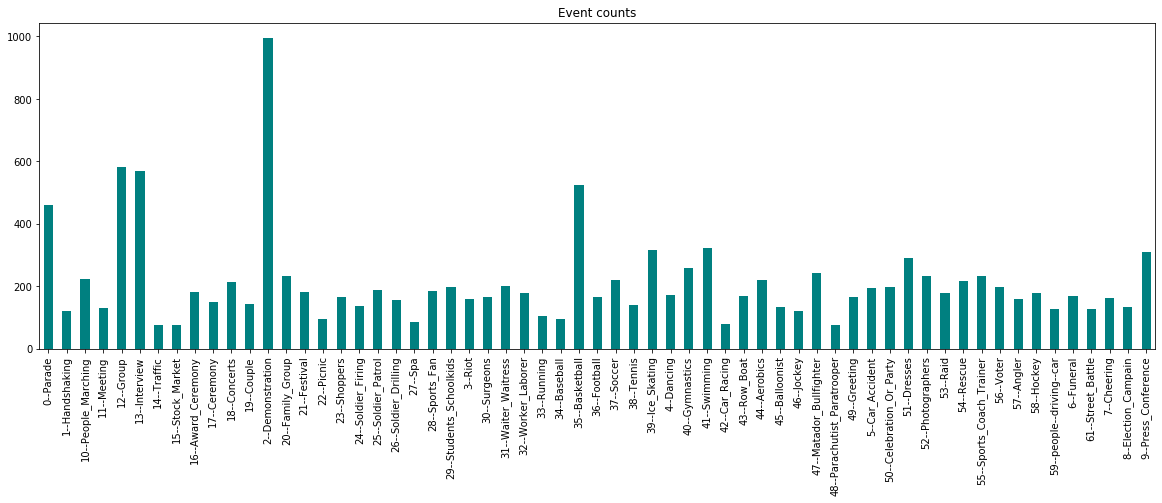

In [29]:
plt.figure(figsize=(20, 6))
train['event_name'].value_counts().sort_index().plot(kind='bar', color='teal');
plt.title('Event counts');

# Check training images

In [351]:
def show_images(df, mode='train'):
    image_count = df.shape[0]
    n = image_count
    assert n <= 16
    row_count = (int) (image_count / n)
    fig, ax = plt.subplots(row_count, n, figsize=(20,10))
    for i, (idx, row) in enumerate(df.iterrows()):
        #print(row)
        x = (int)(i/n)
        y = i%n
        tuple_index = (x,y) if row_count > 1 else y
        
        img_path = f'{DATA_DIR}/{mode}/images/{row.event_name}/{row.img_name}.jpg'
        #print(img_path)
        ax[tuple_index].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))

        # Draw bounding boxes
        for box_idx, bbox in enumerate(row.annotation):
            #print(bbox)
            edgecolor = 'r'
            if mode == 'val':
                if box_idx in row.hard_gt:
                    edgecolor = 'c'
                if box_idx in row.medium_gt:
                    edgecolor = 'b'
                if box_idx in row.easy_gt:
                    edgecolor = 'g'
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=2,edgecolor=edgecolor,facecolor='none')
            ax[tuple_index].add_patch(rect)
        
        # Draw landmarks
        if mode == 'train':
            for ann in row.annotation:
                if ann[4] > 0:
                    for lm_idx in range(5):
                        x, y = ann[4:][lm_idx*2:lm_idx*2+2]
                        lm = patches.Circle((x, y), radius=3, fill=True, color='g')
                        ax[tuple_index].add_patch(lm)
    fig.show()


def show_random_images(df, n=3, mode='train'):
    show_images(df.sample(n), mode=mode)


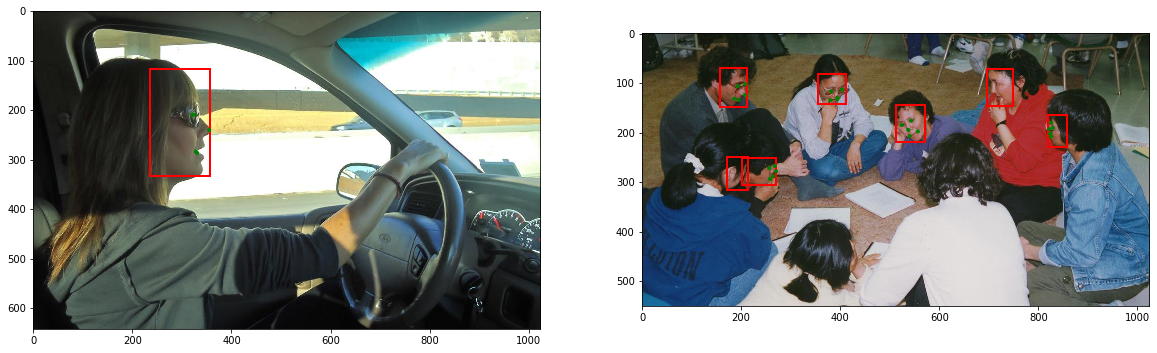

In [327]:
show_random_images(train, 2)

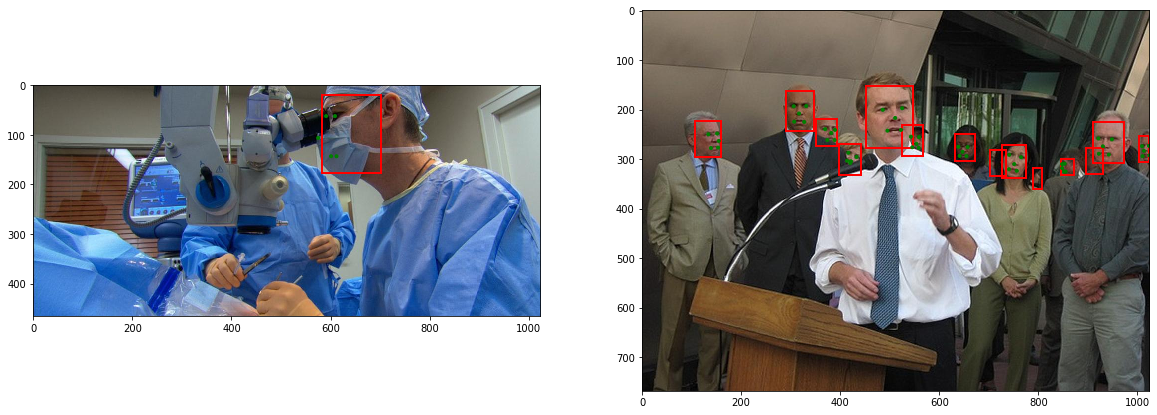

In [179]:
show_random_images(train, 2)

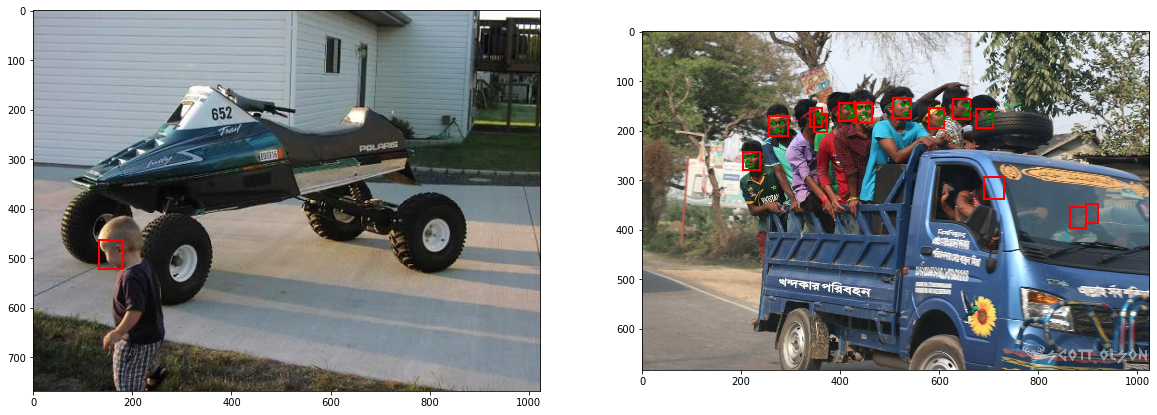

In [192]:
show_random_images(train[train['num_landmarks'] < train['num_bboxes']], 2)

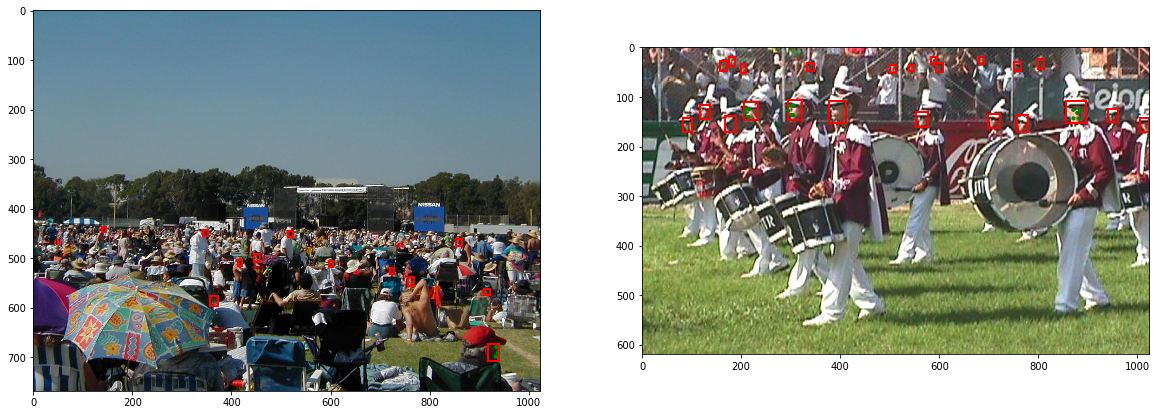

In [193]:
show_random_images(train[train['num_landmarks'] < train['num_bboxes']], 2)

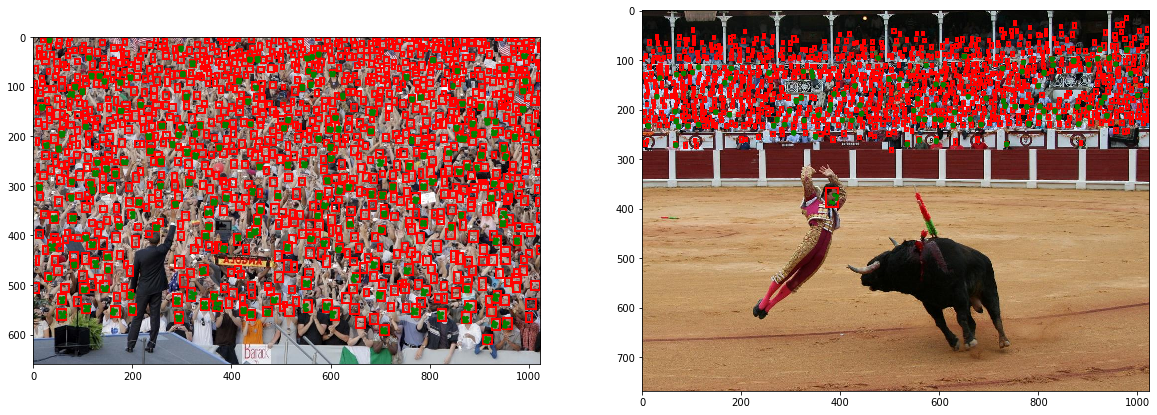

In [194]:
show_random_images(train[train['num_bboxes'] > 1000], 2)

# Evaluation data

In [321]:
def get_gt_boxes(gt_dir):
    """ gt dir: (wider_face_val.mat, wider_easy_val.mat, wider_medium_val.mat, wider_hard_val.mat)"""

    gt_mat = loadmat(os.path.join(gt_dir, 'wider_face_val.mat'))
    hard_mat = loadmat(os.path.join(gt_dir, 'wider_hard_val.mat'))
    medium_mat = loadmat(os.path.join(gt_dir, 'wider_medium_val.mat'))
    easy_mat = loadmat(os.path.join(gt_dir, 'wider_easy_val.mat'))

    facebox_list = gt_mat['face_bbx_list']
    event_list = gt_mat['event_list']
    file_list = gt_mat['file_list']

    hard_gt_list = hard_mat['gt_list']
    medium_gt_list = medium_mat['gt_list']
    easy_gt_list = easy_mat['gt_list']

    return facebox_list, event_list, file_list, hard_gt_list, medium_gt_list, easy_gt_list

In [322]:
facebox_list, event_list, file_list, hard_gt_list, medium_gt_list, easy_gt_list = get_gt_boxes('./widerface_evaluate/ground_truth/')

In [224]:
facebox_list[0][0][0][0].shape

(126, 4)

In [250]:
facebox_list[0].shape

(1,)

In [244]:
event_list[1]

array([array(['1--Handshaking'], dtype='<U14')], dtype=object)

In [258]:
hard_gt_list[0].shape

(1,)

In [230]:
file_list[0][0].shape

(115, 1)

In [323]:
val_labels = []
for faceboxes, events, files, hard_gt, medium_gt, easy_gt \
    in zip(facebox_list, event_list, file_list, hard_gt_list, medium_gt_list, easy_gt_list):
    #print(facebox[0].shape, event_list)
    for i, file in enumerate(files[0]):
        #print(file[0][0], i)
        #print(events[0][0])
        #print(faceboxes[0][i][0])
        #print(hard_gt[0][i][0])
        #print(medium_gt[0][i][0])
        #print(easy_gt[0][i][0])
        #if i == 1:
        #    break
        #if file[0][0] == '16_Award_Ceremony_Awards_Ceremony_16_750':
        #    print(hard_gt[0][i][0], hard_gt[0][i][0].squeeze(-1))
        faceboxes[0][i][0][:, 2] += faceboxes[0][i][0][:, 0]
        faceboxes[0][i][0][:, 3] += faceboxes[0][i][0][:, 1]
        
        if hard_gt[0][i][0].shape[1] == 0:
            h = hard_gt[0][i][0].squeeze()
        else:
            h = hard_gt[0][i][0].squeeze(-1)
        if medium_gt[0][i][0].shape[1] == 0:
            m = medium_gt[0][i][0].squeeze()
        else:
            m = medium_gt[0][i][0].squeeze(-1)
        if easy_gt[0][i][0].shape[1] == 0:
            e = easy_gt[0][i][0].squeeze()
        else:
            e = easy_gt[0][i][0].squeeze(-1)
        
        val_labels.append({
            'event_name': events[0][0],
            'img_name': file[0][0],
            'annotation': faceboxes[0][i][0],
            'hard_gt': h-1,
            'medium_gt': m-1,
            'easy_gt': e-1
        })
    #break

In [324]:
val = pd.DataFrame(val_labels)
val['num_bboxes'] = val.annotation.map(lambda x: len(x))
val.head()

event_name                     img_name  \
0  0--Parade  0_Parade_marchingband_1_465   
1  0--Parade        0_Parade_Parade_0_628   
2  0--Parade  0_Parade_marchingband_1_765   
3  0--Parade        0_Parade_Parade_0_194   
4  0--Parade  0_Parade_marchingband_1_379   

                                          annotation  \
0  [[345, 211, 349, 215], [331, 126, 334, 129], [...   
1  [[26, 299, 36, 315], [25, 329, 32, 340], [84, ...   
2  [[311, 131, 319, 140], [299, 143, 309, 154], [...   
3  [[111, 425, 233, 552], [209, 347, 279, 450], [...   
4  [[281, 303, 301, 339], [260, 324, 276, 345], [...   

                                             hard_gt        medium_gt  \
0                                      [30, 31, 124]               []   
1  [0, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,...     [12, 14, 15]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...               []   
3                                    [0, 1, 2, 3, 4]  [0, 1, 2, 3, 4]   
4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 20,...   [0, 3, 21, 22]   

           easy_gt  num_bboxes  
0               []         126  
1               []          29  
2               []         132  
3  [0, 1, 2, 3, 4]           5  
4               []          26

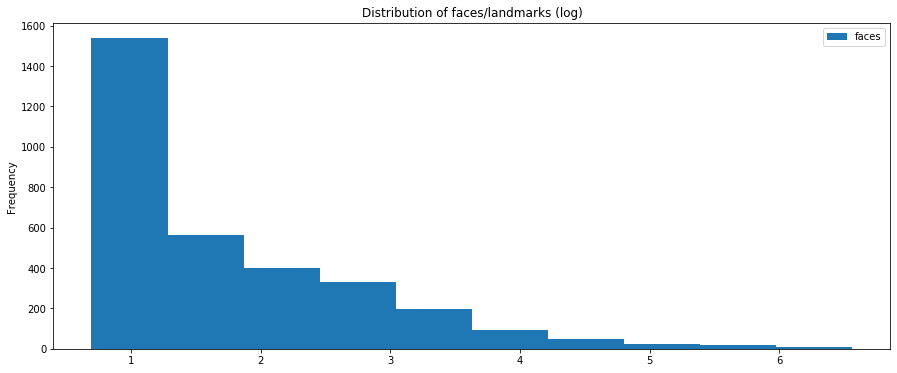

In [315]:
plt.figure(figsize=(15, 6))
plt.title('Distribution of faces/landmarks (log)');
np.log1p(val['num_bboxes']).plot(kind='hist', label='faces');
plt.legend();

In [332]:
val[1:2]

event_name               img_name  \
1  0--Parade  0_Parade_Parade_0_628   

                                          annotation  \
1  [[26, 299, 36, 315], [25, 329, 32, 340], [84, ...   

                                             hard_gt     medium_gt easy_gt  \
1  [0, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,...  [12, 14, 15]      []   

   num_bboxes  
1          29

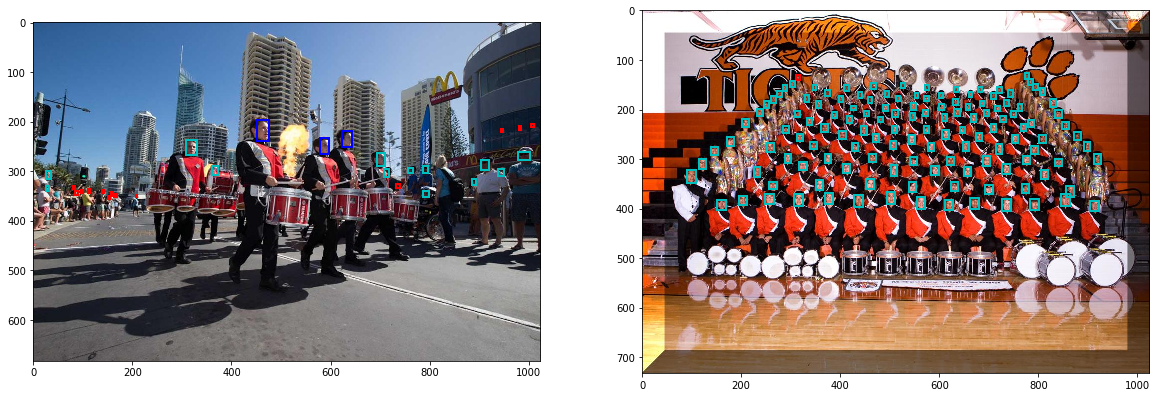

In [352]:
show_random_images(val[1:3], 2, mode='val')

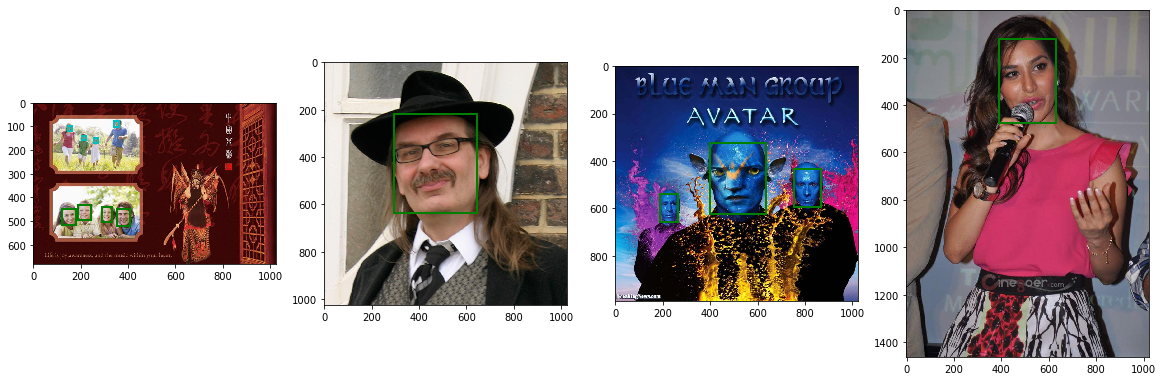

In [353]:
show_random_images(val, 4, mode='val')